## 1. Data Preparation

### Load data

In [1]:
import pandas as pd

df = pd.read_csv("whole Dataset.csv")

In [2]:
df[:5]

,nodule_name,nodule_category,calcification,internal_structure,lobulation,margin,nodule_type,sphericity,texture,global_seed,slice_thickness,slices_present,file_path
0,Small Cell Lung Cancer (SCLC),Malignant,Absent,Soft Tissue,Nn-Mk,P-Sharp,m4,Lin-Ov,NS-PS,3388.5178,2.00,"[53, 54, 55, 56, 57]",../20241221_074106\20241221_074106\LIDC-IDRI\L...
1,Lymphoma,Malignant,Absent,Soft Tissue,N-Marked,Poo-Sh,m7,Ovoid,Part Solid/Mixed,9335.7762,2.00,"[70, 71, 72, 73, 74, 75]",../20241221_074106\20241221_074106\LIDC-IDRI\L...
2,Bronchioloalveolar Hyperplasia,Benign,Absent,Soft Tissue,Nn-Mk,Poorly,b6,Linear,NS-PS,9151.7012,2.50,"[26, 27, 28]",../20241221_074106\20241221_074106\LIDC-IDRI\L...
3,Carcinoid Tumors,Malignant,Non-Central,Soft Tissue,NaN,P-Sharp,m5,Ov-Ro,Solid,201.8990,2.50,"[51, 52, 53]",../20241221_074106\20241221_074106\LIDC-IDRI\L...
4,Intrapulmonary Lymph Nodes,Benign,Absent,Soft Tissue,NaN,Sharp,b7,Ovoid,Solid,8747.3172,1.25,"[23, 24, 25, 26, 27]",../20241221_074106\20241221_074106\LIDC-IDRI\L...


In [3]:
print(len(df))

1487


### Remove 34 nodules with missing annotations

In [4]:
print(df.dtypes)

nodule_name            object
nodule_category        object
calcification          object
internal_structure     object
lobulation             object
margin                 object
nodule_type            object
sphericity             object
texture                object
global_seed           float64
slice_thickness       float64
slices_present         object
file_path              object
dtype: object


In [5]:
import ast

df["slices_present"] = df["slices_present"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

In [6]:
from collections import Counter

length_counts = Counter(len(x) for x in df["slices_present"])
for k in sorted(length_counts):
    print(f"{k} slices: {length_counts[k]} nodules")

0 slices: 34 nodules
1 slices: 18 nodules
2 slices: 239 nodules
3 slices: 376 nodules
4 slices: 196 nodules
5 slices: 163 nodules
6 slices: 142 nodules
7 slices: 123 nodules
8 slices: 88 nodules
9 slices: 50 nodules
10 slices: 15 nodules
11 slices: 16 nodules
12 slices: 6 nodules
13 slices: 12 nodules
14 slices: 7 nodules
18 slices: 1 nodules
19 slices: 1 nodules


In [7]:
df = df[df['slices_present'].apply(lambda x: len(x) > 0)]

In [8]:
print((df['slices_present'].apply(len) == 0).sum())  

0


In [9]:
print(len(df))

1453


### Encoding Labels

In [10]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['label'] = le.fit_transform(df['nodule_name'])

In [11]:
label_map = dict(zip(le.classes_, le.transform(le.classes_)))
print(label_map)

{'Active Infection': 0, 'Adenocarcinoma': 1, 'Adenoid Cystic Carcinoma': 2, 'Bronchioloalveolar Hyperplasia': 3, 'Carcinoid Tumors': 4, 'Granuloma': 5, 'Hamartoma': 6, 'Intrapulmonary Lymph Nodes': 7, 'Large Cell (Undifferentiated) Carcinoma': 8, 'Lymphoma': 9, 'Metastatic Tumors': 10, 'Sarcoidosis': 11, 'Sarcomatoid Carcinoma': 12, 'Small Cell Lung Cancer (SCLC)': 13, 'Squamous Cell Carcinoma': 14}


NOTE: Long covid is not part of this study

# 2. Volume input preprocessing

For each sample:

- volume_local: cropped region centered around nodule (based on segmentation)

- volume_context: full slice (resized to something like 256×256), no crop

In [12]:
# Parse annotaions for bounding box

import json

def load_annotations(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)
    
    annotations = data.get("annotation", [])
    return annotations


In [13]:
# Get nodule centroid

import numpy as np

def polygon_centroid(norm_polygon, img_shape):
    h, w = img_shape
    x_coords = norm_polygon[::2]
    y_coords = norm_polygon[1::2]
    
    # Convert to pixel space
    x_pixels = [x * w for x in x_coords]
    y_pixels = [y * h for y in y_coords]

    x_center = int(np.mean(x_pixels))
    y_center = int(np.mean(y_pixels))

    return x_center, y_center

In [14]:
# Get local crop and global context

import pydicom
import cv2

def process_slice_local_context(dcm_path, segmentation, local_size=(64, 64), context_size=(256, 256)):
    dcm = pydicom.dcmread(dcm_path)
    img = dcm.pixel_array
    h, w = img.shape

    # Normalize pixel values
    img = img.astype(np.float32)
    img = (img - img.min()) / (img.max() - img.min() + 1e-5)

    x_center, y_center = polygon_centroid(segmentation, (h, w))

    # Crop around the center for local view
    half_h, half_w = local_size[0] // 2, local_size[1] // 2
    y1 = max(y_center - half_h, 0)
    y2 = min(y_center + half_h, h)
    x1 = max(x_center - half_w, 0)
    x2 = min(x_center + half_w, w)
    cropped_local = img[y1:y2, x1:x2]

    # Pad if needed
    cropped_local = cv2.resize(cropped_local, local_size)

    # Resize whole slice for context
    resized_context = cv2.resize(img, context_size)

    return cropped_local, resized_context

In [15]:
import os
import re

def remove_leading_duplicate_folder(path):
    """
    Removes the first repeated folder name at the beginning of a path.
    E.g., '../X\\X\\...' → 'X\\...'
    """
    match = re.match(r"^(?:\.\.[\\/])?([^\\/]+)[\\/]\1[\\/](.+)", path)
    if match:
        return f"{match.group(1)}\\{match.group(2)}"
    return path

In [16]:
df['file_path'] = df['file_path'].apply(remove_leading_duplicate_folder)

In [17]:
# Trying with 1 data sample

json_path = df.iloc[0]['file_path'] 


annotations = load_annotations(json_path)

local_slices = []
context_slices = []

for slice_dict in annotations:
    for slice_idx, data in slice_dict.items():
        dcm_filename = os.path.basename(data["dicomFile"])
        dcm_dir = os.path.dirname(json_path)
        dcm_path = os.path.join(dcm_dir, dcm_filename)
        segmentation = data["segmentation"][0]  
        local, context = process_slice_local_context(
            dcm_path, segmentation,
            local_size=(64, 64),
            context_size=(256, 256)
        )
        local_slices.append(local)
        context_slices.append(context)

In [18]:
# Pads or crops a list of 2D slices to a fixed 3D volume.

def pad_or_crop_volume(slices, target_depth, shape):
    D = len(slices)
    h, w = shape

    if D == 0:
        return np.zeros((1, target_depth, h, w), dtype=np.float32)

    volume = np.stack(slices, axis=0)

    if D < target_depth:
        pad_before = (target_depth - D) // 2
        pad_after = target_depth - D - pad_before
        volume = np.pad(volume, ((pad_before, pad_after), (0, 0), (0, 0)), mode='constant')
    elif D > target_depth:
        start = (D - target_depth) // 2
        volume = volume[start:start+target_depth]

    return volume[None, ...]  # Add channel dim: [1, D, H, W]


In [19]:
volume_local = pad_or_crop_volume(local_slices, target_depth=5, shape=(64, 64))
volume_context = pad_or_crop_volume(context_slices, target_depth=7, shape=(256, 256))

print("volume_local shape:", volume_local.shape)
print("volume_context shape:", volume_context.shape)

volume_local shape: (1, 5, 64, 64)
volume_context shape: (1, 7, 256, 256)


In [20]:
# Applying to entire dataset

from tqdm import tqdm

all_locals = []
all_contexts = []
all_labels = []

for _, row in tqdm(df.iterrows(), total=len(df), desc="Processing samples"):
    try:
        json_path = row['file_path']
        label = row['label']
        annotations = load_annotations(json_path)

        local_slices = []
        context_slices = []

        for slice_dict in annotations:
            for slice_idx, data in slice_dict.items():
                
                dcm_filename = os.path.basename(data["dicomFile"])
                dcm_dir = os.path.dirname(json_path)
                dcm_path = os.path.join(dcm_dir, dcm_filename)

                segmentation = data["segmentation"][0]
                local, context = process_slice_local_context(
                    dcm_path, segmentation,
                    local_size=(64, 64),
                    context_size=(256, 256)
                )
                local_slices.append(local)
                context_slices.append(context)

        volume_local = pad_or_crop_volume(local_slices, target_depth=5, shape=(64, 64))
        volume_context = pad_or_crop_volume(context_slices, target_depth=7, shape=(256, 256))

        all_locals.append(volume_local)
        all_contexts.append(volume_context)
        all_labels.append(label)

    except Exception as e:
        print(f"Skipping row due to error: {e}")


Processing samples: 100%|██████████| 1453/1453 [00:20<00:00, 69.93it/s]


# 3. Radiomics preparation

In [21]:
radiomics_columns = [
    "calcification", "internal_structure", "lobulation",
    "margin", "sphericity", "texture"
]

In [22]:
radiomics_df = df[radiomics_columns].copy()

In [23]:
radiomics_encoded = pd.get_dummies(radiomics_df, drop_first=False)

In [24]:
print("Radiomics vector shape:", radiomics_encoded.shape)
radiomics_encoded.head()

Radiomics vector shape: (1453, 25)


,calcification_Absent,calcification_Central,calcification_Laminated,calcification_Non-Central,calcification_Popcorn,calcification_Solid,internal_structure_Soft Tissue,lobulation_Marked,lobulation_N-Marked,lobulation_Nn-Mk,...,margin_Sharp,sphericity_Lin-Ov,sphericity_Linear,sphericity_Ov-Ro,sphericity_Ovoid,sphericity_Round,texture_NS-PS,texture_PS-Solid,texture_Part Solid/Mixed,texture_Solid
0,True,False,False,False,False,False,True,False,False,True,...,False,True,False,False,False,False,True,False,False,False
1,True,False,False,False,False,False,True,False,True,False,...,False,False,False,False,True,False,False,False,True,False
2,True,False,False,False,False,False,True,False,False,True,...,False,False,True,False,False,False,True,False,False,False
3,False,False,False,True,False,False,True,False,False,False,...,False,False,False,True,False,False,False,False,False,True
4,True,False,False,False,False,False,True,False,False,False,...,True,False,False,False,True,False,False,False,False,True


In [25]:
X_radiomics = radiomics_encoded.to_numpy(dtype=np.float32)

In [26]:
X_radiomics.shape

(1453, 25)

# 4. Create Pytorch Dataset

In [27]:
import torch
from torch.utils.data import Dataset

In [28]:
class TripleFusionDataset(Dataset):
    def __init__(self, all_locals, all_contexts, X_radiomics, labels_df):
        self.all_locals = all_locals
        self.all_contexts = all_contexts
        self.radiomics = X_radiomics
        self.labels = labels_df["label"].to_numpy()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        sample = {
            "volume_local": torch.tensor(self.all_locals[idx], dtype=torch.float32),
            "volume_context": torch.tensor(self.all_contexts[idx], dtype=torch.float32),
            "radiomics": torch.tensor(self.radiomics[idx], dtype=torch.float32),
            "label": torch.tensor(self.labels[idx], dtype=torch.long),
        }
        return sample


In [29]:
dataset = TripleFusionDataset(
    all_locals=all_locals,
    all_contexts=all_contexts,
    X_radiomics=X_radiomics,
    labels_df=df  
)

In [30]:
from torch.utils.data import DataLoader

train_loader = DataLoader(dataset, batch_size=16, shuffle=True)

# 5. Triple Fusion Architecture


| Branch           | Input Shape           | Type     |
|------------------|------------------------|----------|
| `volume_local`   | `[B, 1, 5, 64, 64]`     | 3D CNN   |
| `volume_context` | `[B, 1, 7, 256, 256]`   | 3D CNN   |
| `radiomics`      | `[B, 25]`               | MLP      |


In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F

### Local Branch

In [32]:
class LocalBranch(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm3d(16),
            nn.ReLU(),
            nn.MaxPool3d(2),  # (5,64,64) → (2,32,32)

            nn.Conv3d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.MaxPool3d(2),

            nn.Conv3d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.AdaptiveAvgPool3d((1, 1, 1))  # output: [B, 32, 1, 1, 1]
        )

    def forward(self, x):
        x = self.conv(x)
        return x.view(x.size(0), -1)  # flatten to [B, 32]

### Context Branch

In [33]:
class ContextBranch(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm3d(16),
            nn.ReLU(),
            nn.MaxPool3d(2),  # (7,256,256) → (3,128,128)

            nn.Conv3d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.AdaptiveAvgPool3d((1, 1, 1))  # output: [B, 32, 1, 1, 1]
        )

    def forward(self, x):
        x = self.conv(x)
        return x.view(x.size(0), -1)  # [B, 32]

### Radiomics Branch

In [34]:
class RadiomicsBranch(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )

    def forward(self, x):
        return self.fc(x)

### Fusion Model

In [35]:
class TripleFusionModel(nn.Module):
    def __init__(self, num_classes, radiomics_dim=25):
        super().__init__()
        self.local_branch = LocalBranch()
        self.context_branch = ContextBranch()
        self.radiomics_branch = RadiomicsBranch(radiomics_dim)

        self.classifier = nn.Sequential(
            nn.Linear(32 + 32 + 64, 64),  # fuse outputs
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, volume_local, volume_context, radiomics):
        local_feat = self.local_branch(volume_local)
        context_feat = self.context_branch(volume_context)
        radio_feat = self.radiomics_branch(radiomics)

        fused = torch.cat([local_feat, context_feat, radio_feat], dim=1)
        out = self.classifier(fused)
        return out

# 6. Training

In [36]:
import torch.optim as optim

num_classes = len(df["label"].unique())
model = TripleFusionModel(num_classes=num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [37]:
def compute_accuracy(logits, labels):
    preds = torch.argmax(logits, dim=1)
    return (preds == labels).float().mean().item()

In [38]:
from tqdm import tqdm
import time

def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    total_acc = 0.0

    pbar = tqdm(dataloader, desc="Training", leave=False)

    for batch in pbar:
        start_time = time.time()

        vol_local = batch["volume_local"].to(device)
        vol_context = batch["volume_context"].to(device)
        radiomics = batch["radiomics"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()
        outputs = model(vol_local, vol_context, radiomics)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        acc = compute_accuracy(outputs, labels)
        batch_time = time.time() - start_time

        total_loss += loss.item()
        total_acc += acc

        pbar.set_postfix({
            "loss": f"{loss.item():.4f}",
            "acc": f"{acc:.4f}",
            "time": f"{batch_time:.2f}s"
        })

    return total_loss / len(dataloader), total_acc / len(dataloader)


In [39]:
def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_acc = 0.0

    pbar = tqdm(dataloader, desc="Validation", leave=False)

    with torch.no_grad():
        for batch in pbar:
            vol_local = batch["volume_local"].to(device)
            vol_context = batch["volume_context"].to(device)
            radiomics = batch["radiomics"].to(device)
            labels = batch["label"].to(device)

            outputs = model(vol_local, vol_context, radiomics)
            loss = criterion(outputs, labels)
            acc = compute_accuracy(outputs, labels)

            total_loss += loss.item()
            total_acc += acc

            pbar.set_postfix({
                "loss": f"{loss.item():.4f}",
                "acc": f"{acc:.4f}"
            })

    return total_loss / len(dataloader), total_acc / len(dataloader)

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [41]:
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset, DataLoader
all_indices = np.arange(len(dataset))

train_idx, temp_idx = train_test_split(all_indices, test_size=0.2, random_state=42, shuffle=True)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=42, shuffle=True)

train_set = Subset(dataset, train_idx)
val_set = Subset(dataset, val_idx)
test_set = Subset(dataset, test_idx)

train_loader = DataLoader(train_set, batch_size=8, shuffle=True)
val_loader = DataLoader(val_set, batch_size=8, shuffle=False)
test_loader = DataLoader(test_set, batch_size=8, shuffle=False)

In [42]:
num_epochs = 40

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {train_loss:.4f} | Accuracy: {train_acc:.4f}")
    print(f"  Val   Loss: {val_loss:.4f} | Accuracy: {val_acc:.4f}")

Epoch 1/40
  Train Loss: 2.4394 | Accuracy: 0.1909
  Val   Loss: 2.0243 | Accuracy: 0.2500


Epoch 2/40
  Train Loss: 1.8359 | Accuracy: 0.3074
  Val   Loss: 1.6782 | Accuracy: 0.3816


Epoch 3/40
  Train Loss: 1.6539 | Accuracy: 0.3545
  Val   Loss: 1.5354 | Accuracy: 0.5197


Epoch 4/40
  Train Loss: 1.5219 | Accuracy: 0.4349
  Val   Loss: 1.5313 | Accuracy: 0.4211


Epoch 5/40
  Train Loss: 1.4996 | Accuracy: 0.4401
  Val   Loss: 1.4138 | Accuracy: 0.5000


Epoch 6/40
  Train Loss: 1.4266 | Accuracy: 0.4546
  Val   Loss: 1.3216 | Accuracy: 0.5000


Epoch 7/40
  Train Loss: 1.3713 | Accuracy: 0.4957
  Val   Loss: 1.3477 | Accuracy: 0.5000


Epoch 8/40
  Train Loss: 1.3389 | Accuracy: 0.5094
  Val   Loss: 1.4326 | Accuracy: 0.4342


Epoch 9/40
  Train Loss: 1.3176 | Accuracy: 0.5188
  Val   Loss: 1.3579 | Accuracy: 0.5000


Epoch 10/40
  Train Loss: 1.3045 | Accuracy: 0.5103
  Val   Loss: 1.3017 | Accuracy: 0.4934


Epoch 11/40
  Train Loss: 1.2733 | Accuracy: 0.5351
  Val   Loss: 1.2750 | Accuracy: 0.5000


Epoch 12/40
  Train Loss: 1.2191 | Accuracy: 0.5479
  Val   Loss: 1.2722 | Accuracy: 0.5263


Epoch 13/40
  Train Loss: 1.2177 | Accuracy: 0.5479
  Val   Loss: 1.3172 | Accuracy: 0.5000


Epoch 14/40
  Train Loss: 1.1903 | Accuracy: 0.5668
  Val   Loss: 1.2786 | Accuracy: 0.5395


Epoch 15/40
  Train Loss: 1.1839 | Accuracy: 0.5651
  Val   Loss: 1.2778 | Accuracy: 0.5329


Epoch 16/40
  Train Loss: 1.1784 | Accuracy: 0.5557
  Val   Loss: 1.3246 | Accuracy: 0.5000


Epoch 17/40
  Train Loss: 1.1284 | Accuracy: 0.5753
  Val   Loss: 1.2968 | Accuracy: 0.5000


Epoch 18/40
  Train Loss: 1.0911 | Accuracy: 0.5993
  Val   Loss: 1.2652 | Accuracy: 0.5789


Epoch 19/40
  Train Loss: 1.1128 | Accuracy: 0.6002
  Val   Loss: 1.3119 | Accuracy: 0.5329


Epoch 20/40
  Train Loss: 1.0436 | Accuracy: 0.6156
  Val   Loss: 1.1350 | Accuracy: 0.5329


Epoch 21/40
  Train Loss: 1.0559 | Accuracy: 0.6070
  Val   Loss: 1.4756 | Accuracy: 0.4408


Epoch 22/40
  Train Loss: 1.0154 | Accuracy: 0.6284
  Val   Loss: 1.3237 | Accuracy: 0.5263


Epoch 23/40
  Train Loss: 1.0482 | Accuracy: 0.6113
  Val   Loss: 1.3397 | Accuracy: 0.5263


Epoch 24/40
  Train Loss: 0.9844 | Accuracy: 0.6404
  Val   Loss: 1.2405 | Accuracy: 0.5395


Epoch 25/40
  Train Loss: 0.9789 | Accuracy: 0.6438
  Val   Loss: 1.5344 | Accuracy: 0.4737


Epoch 26/40
  Train Loss: 0.9721 | Accuracy: 0.6438
  Val   Loss: 1.2274 | Accuracy: 0.5132


Epoch 27/40
  Train Loss: 0.9634 | Accuracy: 0.6541
  Val   Loss: 1.2060 | Accuracy: 0.5987


Epoch 28/40
  Train Loss: 0.9460 | Accuracy: 0.6490
  Val   Loss: 1.1913 | Accuracy: 0.5658


Epoch 29/40
  Train Loss: 0.9412 | Accuracy: 0.6498
  Val   Loss: 1.2767 | Accuracy: 0.5526


Epoch 30/40
  Train Loss: 0.9012 | Accuracy: 0.6738
  Val   Loss: 1.2402 | Accuracy: 0.5395


Epoch 31/40
  Train Loss: 0.9293 | Accuracy: 0.6704
  Val   Loss: 1.3211 | Accuracy: 0.4934


Epoch 32/40
  Train Loss: 0.8643 | Accuracy: 0.6652
  Val   Loss: 1.2118 | Accuracy: 0.5526


Epoch 33/40
  Train Loss: 0.8808 | Accuracy: 0.6755
  Val   Loss: 1.1755 | Accuracy: 0.5461


Epoch 34/40
  Train Loss: 0.8758 | Accuracy: 0.6687
  Val   Loss: 1.2042 | Accuracy: 0.5395


Epoch 35/40
  Train Loss: 0.8331 | Accuracy: 0.6969
  Val   Loss: 1.1640 | Accuracy: 0.5526


Epoch 36/40
  Train Loss: 0.8176 | Accuracy: 0.6995
  Val   Loss: 1.1896 | Accuracy: 0.4934


Epoch 37/40
  Train Loss: 0.8913 | Accuracy: 0.6652
  Val   Loss: 1.2701 | Accuracy: 0.5263


Epoch 38/40
  Train Loss: 0.8057 | Accuracy: 0.7123
  Val   Loss: 1.3641 | Accuracy: 0.5132


Epoch 39/40
  Train Loss: 0.8191 | Accuracy: 0.6995
  Val   Loss: 1.1607 | Accuracy: 0.6118


Epoch 40/40
  Train Loss: 0.7999 | Accuracy: 0.6978
  Val   Loss: 1.2115 | Accuracy: 0.5658


In [43]:
num_epochs = 40

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {train_loss:.4f} | Accuracy: {train_acc:.4f}")
    print(f"  Val   Loss: {val_loss:.4f} | Accuracy: {val_acc:.4f}")

Epoch 1/40
  Train Loss: 0.7800 | Accuracy: 0.6969
  Val   Loss: 1.1539 | Accuracy: 0.5461


Epoch 2/40
  Train Loss: 0.7830 | Accuracy: 0.7038
  Val   Loss: 1.3025 | Accuracy: 0.5724


Epoch 3/40
  Train Loss: 0.7859 | Accuracy: 0.7055
  Val   Loss: 1.2325 | Accuracy: 0.5526


Epoch 4/40
  Train Loss: 0.7585 | Accuracy: 0.7149
  Val   Loss: 1.1558 | Accuracy: 0.5724


Epoch 5/40
  Train Loss: 0.7133 | Accuracy: 0.7372
  Val   Loss: 1.2486 | Accuracy: 0.5855


Epoch 6/40
  Train Loss: 0.7685 | Accuracy: 0.7158
  Val   Loss: 1.3361 | Accuracy: 0.5132


Epoch 7/40
  Train Loss: 0.7544 | Accuracy: 0.7200
  Val   Loss: 1.2191 | Accuracy: 0.5789


Epoch 8/40
  Train Loss: 0.6972 | Accuracy: 0.7329
  Val   Loss: 1.3723 | Accuracy: 0.5461


Epoch 9/40
  Train Loss: 0.7392 | Accuracy: 0.7295
  Val   Loss: 1.4322 | Accuracy: 0.5329


Epoch 10/40
  Train Loss: 0.7081 | Accuracy: 0.7260
  Val   Loss: 1.3187 | Accuracy: 0.5724


Epoch 11/40
  Train Loss: 0.6716 | Accuracy: 0.7620
  Val   Loss: 1.2577 | Accuracy: 0.5724


Epoch 12/40
  Train Loss: 0.7118 | Accuracy: 0.7449
  Val   Loss: 1.4178 | Accuracy: 0.5395


Epoch 13/40
  Train Loss: 0.6660 | Accuracy: 0.7517
  Val   Loss: 1.4422 | Accuracy: 0.5526


Epoch 14/40
  Train Loss: 0.6875 | Accuracy: 0.7526
  Val   Loss: 1.2481 | Accuracy: 0.5329


Epoch 15/40
  Train Loss: 0.6833 | Accuracy: 0.7543
  Val   Loss: 1.3937 | Accuracy: 0.5592


Epoch 16/40
  Train Loss: 0.6354 | Accuracy: 0.7680
  Val   Loss: 1.3068 | Accuracy: 0.5921


Epoch 17/40
  Train Loss: 0.5933 | Accuracy: 0.7765
  Val   Loss: 1.5631 | Accuracy: 0.5132


Epoch 18/40
  Train Loss: 0.6251 | Accuracy: 0.7663
  Val   Loss: 1.2505 | Accuracy: 0.5658


Epoch 19/40
  Train Loss: 0.5826 | Accuracy: 0.7902
  Val   Loss: 1.4479 | Accuracy: 0.5461


Epoch 20/40
  Train Loss: 0.6002 | Accuracy: 0.7868
  Val   Loss: 1.4630 | Accuracy: 0.5592


Epoch 21/40
  Train Loss: 0.5894 | Accuracy: 0.7928
  Val   Loss: 1.2803 | Accuracy: 0.5461


Epoch 22/40
  Train Loss: 0.6085 | Accuracy: 0.7800
  Val   Loss: 1.4177 | Accuracy: 0.6316


Epoch 23/40
  Train Loss: 0.6069 | Accuracy: 0.7868
  Val   Loss: 1.4282 | Accuracy: 0.5461


Epoch 24/40
  Train Loss: 0.5862 | Accuracy: 0.7902
  Val   Loss: 1.4256 | Accuracy: 0.5461


Epoch 25/40
  Train Loss: 0.5365 | Accuracy: 0.8159
  Val   Loss: 1.3305 | Accuracy: 0.5658


Epoch 26/40
  Train Loss: 0.5772 | Accuracy: 0.7877
  Val   Loss: 1.2830 | Accuracy: 0.5987


Epoch 27/40
  Train Loss: 0.5423 | Accuracy: 0.8057
  Val   Loss: 1.6675 | Accuracy: 0.5395


Epoch 28/40
  Train Loss: 0.5313 | Accuracy: 0.7997
  Val   Loss: 1.3222 | Accuracy: 0.5987


Epoch 29/40
  Train Loss: 0.5321 | Accuracy: 0.8014
  Val   Loss: 1.6336 | Accuracy: 0.5263


Epoch 30/40
  Train Loss: 0.5177 | Accuracy: 0.8134
  Val   Loss: 1.1878 | Accuracy: 0.5855


Epoch 31/40
  Train Loss: 0.5009 | Accuracy: 0.8193
  Val   Loss: 1.4918 | Accuracy: 0.5987


Epoch 32/40
  Train Loss: 0.5112 | Accuracy: 0.8159
  Val   Loss: 1.3925 | Accuracy: 0.5855


Epoch 33/40
  Train Loss: 0.5201 | Accuracy: 0.8065
  Val   Loss: 1.5385 | Accuracy: 0.5461


Epoch 34/40
  Train Loss: 0.5106 | Accuracy: 0.8151
  Val   Loss: 1.5807 | Accuracy: 0.5724


Epoch 35/40
  Train Loss: 0.5035 | Accuracy: 0.8116
  Val   Loss: 1.5683 | Accuracy: 0.5789


Epoch 36/40
  Train Loss: 0.5045 | Accuracy: 0.7997
  Val   Loss: 1.6332 | Accuracy: 0.5461


Epoch 37/40
  Train Loss: 0.4941 | Accuracy: 0.8142
  Val   Loss: 1.4826 | Accuracy: 0.5987


Epoch 38/40
  Train Loss: 0.4565 | Accuracy: 0.8382
  Val   Loss: 1.2894 | Accuracy: 0.5921


Epoch 39/40
  Train Loss: 0.4427 | Accuracy: 0.8305
  Val   Loss: 1.5343 | Accuracy: 0.6053


Epoch 40/40
  Train Loss: 0.4329 | Accuracy: 0.8408
  Val   Loss: 1.5464 | Accuracy: 0.5658


# 7. Evaluation

NOTE: I forgot to do a test dataset split so I'm currently gonna get a random subset

In [44]:
def predict(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            vol_local = batch["volume_local"].to(device)
            vol_context = batch["volume_context"].to(device)
            radiomics = batch["radiomics"].to(device)
            labels = batch["label"].to(device)

            outputs = model(vol_local, vol_context, radiomics)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)

In [45]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, dataloader, device, class_names):
    y_pred, y_true = predict(model, dataloader, device)

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average="weighted")

    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()


Accuracy: 0.5616
F1 Score: 0.5579

Classification Report:
                                         precision    recall  f1-score   support

                       Active Infection       0.60      0.60      0.60        10
                         Adenocarcinoma       0.44      0.44      0.44         9
               Adenoid Cystic Carcinoma       0.50      0.22      0.31         9
         Bronchioloalveolar Hyperplasia       0.41      0.71      0.52        17
                       Carcinoid Tumors       1.00      0.73      0.84        11
                              Granuloma       0.83      0.75      0.79        20
                              Hamartoma       1.00      1.00      1.00         5
             Intrapulmonary Lymph Nodes       0.70      0.88      0.78         8
Large Cell (Undifferentiated) Carcinoma       0.29      0.25      0.27         8
                               Lymphoma       0.67      0.40      0.50        10
                      Metastatic Tumors       0.43

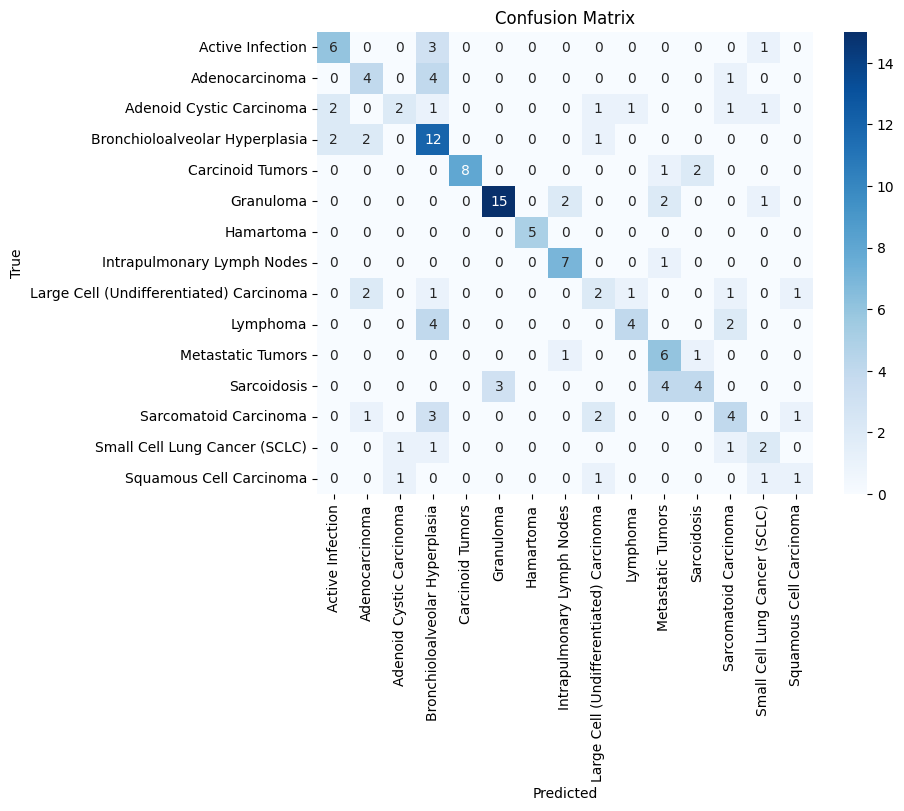

In [46]:
class_names = list(le.classes_)
evaluate_model(model, test_loader, device, class_names)

# 8. Explainability

### Grad-Cam

In [47]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [48]:
target_layer = model.local_branch.conv[4]  # the second Conv3D layer

In [49]:
cam = GradCAM(model=model.local_branch, target_layers=[target_layer])

batch = next(iter(test_loader))  # one batch
input_tensor = batch["volume_local"][0].unsqueeze(0).to(device)  # [1, 1, D, H, W]
target_category = batch["label"][0].item()

grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(target_category)])


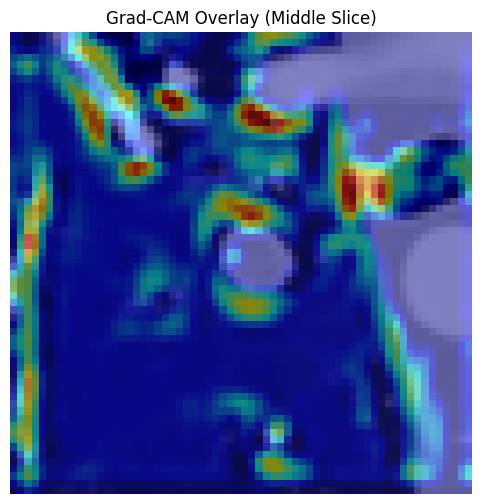

In [50]:
# Visualize the heatmap 

input_volume = batch["volume_local"][0].squeeze(0).cpu().numpy() 

def normalize(x):
    x = x - x.min()
    x = x / (x.max() + 1e-5)
    return x

volume = batch["volume_local"][0].squeeze(0).cpu().numpy()      
grayscale = grayscale_cam[0]                                    

# Take the middle slice
mid = volume.shape[0] // 2
slice_img = normalize(volume[mid])
cam_slice = normalize(grayscale[mid])

if cam_slice.shape != slice_img.shape:
    cam_slice = cv2.resize(cam_slice, slice_img.shape[::-1])

# Convert CAM to heatmap
cam_uint8 = np.ascontiguousarray((cam_slice * 255).astype(np.uint8))
heatmap = cv2.applyColorMap(cam_uint8, cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) / 255.0

# Prepare grayscale CT image
ct_rgb = np.stack([slice_img] * 3, axis=-1)

overlay = 0.5 * ct_rgb + 0.5 * heatmap

plt.figure(figsize=(6, 6))
plt.imshow(overlay)
plt.title("Grad-CAM Overlay (Middle Slice)")
plt.axis("off")
plt.show()

# 9. Save model

In [51]:
torch.save(model.state_dict(), "triple_fusion_model.pkl")